In [1]:
# Copyright 2025 Andrew Lehr
# The MIT License

## Supplementary Figure 6
#### Spontaneous sequences under background noise

### Imports

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from brian2 import *
import time
from datetime import datetime
from scipy import signal
from scipy import io

In [2]:
from spreizer_net import SpreizerNet
import params

### Parameters

In [12]:
data_dir = '/home/andrew/Documents/projects/submanifolds/subspace_projections_with_selective_inhibition/spiking_network/background_noise_simulations/saves/spike_monitors/'
figs_dir = '/home/andrew/Documents/projects/submanifolds/subspace_projections_with_selective_inhibition/spiking_network/background_noise_simulations/figures/'
simtime = 2000
nPopE = params.network_dimensions['n_pop_e']
nPopI = params.network_dimensions['n_pop_i']
seed_value = 0

In [4]:
colors = ['#586ba4', '#f68e5f', '#f5dd90', '#324376', '#f76c5e', 
          '#067d7a', '#77c1b3', '#f3c759', '#ed7364', '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

### Initialize and store network

In [5]:
sn = SpreizerNet()  
sn.set_seed()  
sn.populate()  
sn.connect()  
#sn.connect_external_input(spike_idcs, pulse_time=0*ms, mean_stim=1.1, sigma_stim=0.)
sn.set_initial_potentials()  
sn.connect_spike_monitors() 
sn.store_network() 

Je_orig = sn.synapses['ee'].namespace['Je']

In [6]:
from collections import defaultdict

np.random.seed(0)

p_offs = np.array([0,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).round(2) 
n_p_offs = len(p_offs)
n_subspaces = 5
inh_input = 500
neuron_list_e = np.arange(0,nPopE)
neuron_list_i = np.arange(0,nPopI)
subsets_e = defaultdict(dict)
subsets_i = defaultdict(dict)
on_offs_e = defaultdict(dict)
on_offs_i = defaultdict(dict)

for p_off_i, p_off in enumerate(p_offs):
    n_off_e = int(p_off*nPopE)
    n_off_i = int(p_off*nPopI)

    subsets_i[p_off] = np.random.choice(neuron_list_i, n_off_i, replace=False)
    on_offs_i[p_off] = np.zeros(nPopI)
    on_offs_i[p_off][subsets_i[p_off]] = inh_input 
    
    for subspace in range(n_subspaces):
        
        subsets_e[p_off, subspace] = np.random.choice(neuron_list_e, n_off_e, replace=False)
        on_offs_e[p_off, subspace] = np.zeros(nPopE)
        on_offs_e[p_off, subspace][subsets_e[p_off, subspace]] = inh_input

In [7]:
angles = np.zeros((len(p_offs), int(n_subspaces*(n_subspaces-1)/2)))
for p_off_i, p_off in enumerate(p_offs):
    i = 0
    for subspace_i in range(n_subspaces):
        for subspace_j in range(subspace_i+1, n_subspaces):

            pi = (on_offs_e[p_off, subspace_i] == 0).astype(int)
            pj = (on_offs_e[p_off, subspace_j] == 0).astype(int)
            
            cos_theta = np.dot(pi,pj) / (np.linalg.norm(pi) * np.linalg.norm(pj))
            angles[p_off_i, i] = np.arccos(np.clip(cos_theta,-1,1))*180/np.pi
            i = i + 1

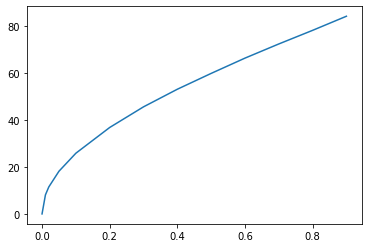

In [8]:
plt.plot(p_offs, angles.mean(axis=1))

### Multiple subsets

In [9]:
n_trials = 1  #10

In [11]:
np.random.seed(seed_value)

for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):

        on_off_e = on_offs_e[p_off, subspace]
        on_off_i = on_offs_i[p_off]
        
        for trial in range(n_trials):
            sn.restore_network()
            #sn.synapses['ee'].namespace['Je'] = Je_orig / (1 - p_off)
            seed(seed_value + trial)
            np.random.seed(seed_value + trial)
            sn.network.set_states({'e_neurons': {'on_or_off': on_off_e}})
            sn.network.set_states({'i_neurons': {'on_or_off': on_off_i}})
            sn.run_sim(simulation_time=simtime*ms)  
            sn.save_monitors('bg_noise_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial))
            print ('pinh:' + str(p_off) + ', subspace:' + str(subspace) + ', trial:' + str(trial), end="\r")

Starting simulation at t=0. s for a duration of 2. s
173.7 ms (8%) simulated in 2s, estimated 21s remaining.
0.3344 s (16%) simulated in 4s, estimated 20s remaining.
0.4935 s (24%) simulated in 6s, estimated 18s remaining.
0.6551 s (32%) simulated in 8s, estimated 16s remaining.
0.808 s (40%) simulated in 10s, estimated 15s remaining.
0.9694 s (48%) simulated in 12s, estimated 13s remaining.
1.1475 s (57%) simulated in 14s, estimated 10s remaining.
1.3191 s (65%) simulated in 16s, estimated 8s remaining.
1.4848 s (74%) simulated in 18s, estimated 6s remaining.
1.6561 s (82%) simulated in 20s, estimated 4s remaining.
1.8331 s (91%) simulated in 22s, estimated 2s remaining.
1.9821 s (99%) simulated in 24s, estimated < 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
178.8 ms (8%) simulated in 2s, estimated 20s remaining.
0.3427 s (17%) simulated in 4s, estimated 19s remaining.
0.5151 s (25%) simulated in 6s, estimated 17s remaining.
0.6844 s (34%) simulated in 8s, estimated 15s remaining.
0.8532 s (42%) simulated in 10s, estimated 13s remaining.
1.0311 s (51%) simulated in 12s, estimated 11s remaining.
1.2059 s (60%) simulated in 14s, estimated 9s remaining.
1.3781 s (68%) simulated in 16s, estimated 7s remaining.
1.551 s (77%) simulated in 18s, estimated 5s remaining.
1.7122 s (85%) simulated in 20s, estimated 3s remaining.
1.8691 s (93%) simulated in 22s, estimated 2s remaining.
2. s (100%) simulated in 23s


Starting simulation at t=0. s for a duration of 2. s
161.9 ms (8%) simulated in 2s, estimated 23s remaining.
0.3195 s (15%) simulated in 4s, estimated 21s remaining.
0.4912 s (24%) simulated in 6s, estimated 18s remaining.
0.6494 s (32%) simulated in 8s, estimated 17s remaining.
0.82 s (41%) simulated in 10s, estimated 14s remaining.
0.9941 s (49%) simulated in 12s, estimated 12s remaining.
1.1496 s (57%) simulated in 14s, estimated 10s remaining.
1.3001 s (65%) simulated in 16s, estimated 9s remaining.
1.4445 s (72%) simulated in 18s, estimated 7s remaining.
1.6024 s (80%) simulated in 20s, estimated 5s remaining.
1.7703 s (88%) simulated in 22s, estimated 3s remaining.
1.942 s (97%) simulated in 24s, estimated 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
156.6 ms (7%) simulated in 2s, estimated 24s remaining.
0.3457 s (17%) simulated in 4s, estimated 19s remaining.
0.5236 s (26%) simulated in 6s, estimated 17s remaining.
0.7067 s (35%) simulated in 8s, estimated 15s remaining.
0.8865 s (44%) simulated in 10s, estimated 13s remaining.
1.0564 s (52%) simulated in 12s, estimated 11s remaining.
1.2322 s (61%) simulated in 14s, estimated 9s remaining.
1.4046 s (70%) simulated in 16s, estimated 7s remaining.
1.5638 s (78%) simulated in 18s, estimated 5s remaining.
1.7299 s (86%) simulated in 20s, estimated 3s remaining.
1.9029 s (95%) simulated in 22s, estimated 1s remaining.
2. s (100%) simulated in 23s


Starting simulation at t=0. s for a duration of 2. s
179.4 ms (8%) simulated in 2s, estimated 20s remaining.
0.3249 s (16%) simulated in 4s, estimated 21s remaining.
0.4764 s (23%) simulated in 6s, estimated 19s remaining.
0.6368 s (31%) simulated in 8s, estimated 17s remaining.
0.7828 s (39%) simulated in 10s, estimated 16s remaining.
0.9504 s (47%) simulated in 12s, estimated 13s remaining.
1.1227 s (56%) simulated in 14s, estimated 11s remaining.
1.2917 s (64%) simulated in 16s, estimated 9s remaining.
1.4552 s (72%) simulated in 18s, estimated 7s remaining.
1.6229 s (81%) simulated in 20s, estimated 5s remaining.
1.7716 s (88%) simulated in 22s, estimated 3s remaining.
1.9105 s (95%) simulated in 24s, estimated 1s remaining.
2. s (100%) simulated in 25s


Starting simulation at t=0. s for a duration of 2. s
187.1 ms (9%) simulated in 2s, estimated 19s remaining.
0.3579 s (17%) simulated in 4s, estimated 18s remaining.
0.5401 s (27%) simulated in 6s, estimated 16s remaining.
0.7232 s (36%) simulated in 8s, estimated 14s remaining.
0.9045 s (45%) simulated in 10s, estimated 12s remaining.
1.0866 s (54%) simulated in 12s, estimated 10s remaining.
1.2556 s (62%) simulated in 14s, estimated 8s remaining.
1.4024 s (70%) simulated in 16s, estimated 7s remaining.
1.5736 s (78%) simulated in 18s, estimated 5s remaining.
1.7384 s (86%) simulated in 20s, estimated 3s remaining.
1.9027 s (95%) simulated in 22s, estimated 1s remaining.
2. s (100%) simulated in 23s


Starting simulation at t=0. s for a duration of 2. s
177.2 ms (8%) simulated in 2s, estimated 21s remaining.
0.3484 s (17%) simulated in 4s, estimated 19s remaining.
0.5072 s (25%) simulated in 6s, estimated 18s remaining.
0.6567 s (32%) simulated in 8s, estimated 16s remaining.
0.8141 s (40%) simulated in 10s, estimated 15s remaining.
0.9784 s (48%) simulated in 12s, estimated 13s remaining.
1.1301 s (56%) simulated in 14s, estimated 11s remaining.
1.2864 s (64%) simulated in 16s, estimated 9s remaining.
1.4503 s (72%) simulated in 18s, estimated 7s remaining.
1.6179 s (80%) simulated in 20s, estimated 5s remaining.
1.7924 s (89%) simulated in 22s, estimated 3s remaining.
1.9465 s (97%) simulated in 24s, estimated 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
183.7 ms (9%) simulated in 2s, estimated 20s remaining.
0.3409 s (17%) simulated in 4s, estimated 19s remaining.
0.4982 s (24%) simulated in 6s, estimated 18s remaining.
0.6407 s (32%) simulated in 8s, estimated 17s remaining.
0.7966 s (39%) simulated in 10s, estimated 15s remaining.
0.9611 s (48%) simulated in 12s, estimated 13s remaining.
1.1363 s (56%) simulated in 14s, estimated 11s remaining.
1.326 s (66%) simulated in 16s, estimated 8s remaining.
1.4956 s (74%) simulated in 18s, estimated 6s remaining.
1.6829 s (84%) simulated in 20s, estimated 4s remaining.
1.8539 s (92%) simulated in 22s, estimated 2s remaining.
2. s (100%) simulated in 23s


Starting simulation at t=0. s for a duration of 2. s
193.9 ms (9%) simulated in 2s, estimated 19s remaining.
0.3649 s (18%) simulated in 4s, estimated 18s remaining.
0.5282 s (26%) simulated in 6s, estimated 17s remaining.
0.6622 s (33%) simulated in 8s, estimated 16s remaining.
0.7944 s (39%) simulated in 10s, estimated 15s remaining.
0.9349 s (46%) simulated in 12s, estimated 14s remaining.
1.0812 s (54%) simulated in 14s, estimated 12s remaining.
1.2259 s (61%) simulated in 16s, estimated 10s remaining.
1.3691 s (68%) simulated in 18s, estimated 8s remaining.
1.5139 s (75%) simulated in 20s, estimated 6s remaining.
1.6722 s (83%) simulated in 22s, estimated 4s remaining.
1.8249 s (91%) simulated in 24s, estimated 2s remaining.
1.9668 s (98%) simulated in 26s, estimated < 1s remaining.
2. s (100%) simulated in 26s


Starting simulation at t=0. s for a duration of 2. s
164. ms (8%) simulated in 2s, estimated 22s remaining.
0.3206 s (16%) simulated in 4s, estimated 21s remaining.
0.4863 s (24%) simulated in 6s, estimated 19s remaining.
0.6394 s (31%) simulated in 8s, estimated 17s remaining.
0.7983 s (39%) simulated in 10s, estimated 15s remaining.
0.9697 s (48%) simulated in 12s, estimated 13s remaining.
1.1182 s (55%) simulated in 14s, estimated 11s remaining.
1.2723 s (63%) simulated in 16s, estimated 9s remaining.
1.4325 s (71%) simulated in 18s, estimated 7s remaining.
1.6008 s (80%) simulated in 20s, estimated 5s remaining.
1.7691 s (88%) simulated in 22s, estimated 3s remaining.
1.9321 s (96%) simulated in 24s, estimated 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
171.8 ms (8%) simulated in 2s, estimated 21s remaining.
0.3393 s (16%) simulated in 4s, estimated 20s remaining.
0.5107 s (25%) simulated in 6s, estimated 18s remaining.
0.6765 s (33%) simulated in 8s, estimated 16s remaining.
0.8417 s (42%) simulated in 10s, estimated 14s remaining.
0.994 s (49%) simulated in 12s, estimated 12s remaining.
1.1623 s (58%) simulated in 14s, estimated 10s remaining.
1.3335 s (66%) simulated in 16s, estimated 8s remaining.
1.5009 s (75%) simulated in 18s, estimated 6s remaining.
1.6604 s (83%) simulated in 20s, estimated 4s remaining.
1.8301 s (91%) simulated in 22s, estimated 2s remaining.
1.9933 s (99%) simulated in 24s, estimated < 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
180. ms (9%) simulated in 2s, estimated 20s remaining.
0.3366 s (16%) simulated in 4s, estimated 20s remaining.
0.4997 s (24%) simulated in 6s, estimated 18s remaining.
0.6574 s (32%) simulated in 8s, estimated 16s remaining.
0.8171 s (40%) simulated in 10s, estimated 14s remaining.
0.9885 s (49%) simulated in 12s, estimated 12s remaining.
1.1598 s (57%) simulated in 14s, estimated 10s remaining.
1.3174 s (65%) simulated in 16s, estimated 8s remaining.
1.4831 s (74%) simulated in 18s, estimated 6s remaining.
1.6494 s (82%) simulated in 20s, estimated 4s remaining.
1.8215 s (91%) simulated in 22s, estimated 2s remaining.
1.9983 s (99%) simulated in 24s, estimated < 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
167.4 ms (8%) simulated in 2s, estimated 22s remaining.
0.3231 s (16%) simulated in 4s, estimated 21s remaining.
0.4961 s (24%) simulated in 6s, estimated 18s remaining.
0.6618 s (33%) simulated in 8s, estimated 16s remaining.
0.8287 s (41%) simulated in 10s, estimated 14s remaining.
0.995 s (49%) simulated in 12s, estimated 12s remaining.
1.1495 s (57%) simulated in 14s, estimated 10s remaining.
1.3099 s (65%) simulated in 16s, estimated 8s remaining.
1.4824 s (74%) simulated in 18s, estimated 6s remaining.
1.6568 s (82%) simulated in 20s, estimated 4s remaining.
1.8184 s (90%) simulated in 22s, estimated 2s remaining.
1.9848 s (99%) simulated in 24s, estimated < 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
173.5 ms (8%) simulated in 2s, estimated 21s remaining.
0.3381 s (16%) simulated in 4s, estimated 20s remaining.
0.514 s (25%) simulated in 6s, estimated 17s remaining.
0.6702 s (33%) simulated in 8s, estimated 16s remaining.
0.8381 s (41%) simulated in 10s, estimated 14s remaining.
1.0055 s (50%) simulated in 12s, estimated 12s remaining.
1.1713 s (58%) simulated in 14s, estimated 10s remaining.
1.3391 s (66%) simulated in 16s, estimated 8s remaining.
1.5048 s (75%) simulated in 18s, estimated 6s remaining.
1.6583 s (82%) simulated in 20s, estimated 4s remaining.
1.8299 s (91%) simulated in 22s, estimated 2s remaining.
1.9875 s (99%) simulated in 24s, estimated < 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
153.6 ms (7%) simulated in 2s, estimated 24s remaining.
303.4 ms (15%) simulated in 4s, estimated 22s remaining.
0.4631 s (23%) simulated in 6s, estimated 20s remaining.
0.6311 s (31%) simulated in 8s, estimated 17s remaining.
0.8013 s (40%) simulated in 10s, estimated 15s remaining.
0.9429 s (47%) simulated in 12s, estimated 13s remaining.
1.0951 s (54%) simulated in 14s, estimated 12s remaining.
1.2748 s (63%) simulated in 16s, estimated 9s remaining.
1.4497 s (72%) simulated in 18s, estimated 7s remaining.
1.6332 s (81%) simulated in 20s, estimated 4s remaining.
1.8108 s (90%) simulated in 22s, estimated 2s remaining.
1.9749 s (98%) simulated in 24s, estimated < 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
193.5 ms (9%) simulated in 2s, estimated 19s remaining.
0.3565 s (17%) simulated in 4s, estimated 18s remaining.
0.5304 s (26%) simulated in 6s, estimated 17s remaining.
0.7144 s (35%) simulated in 8s, estimated 14s remaining.
0.8932 s (44%) simulated in 10s, estimated 12s remaining.
1.0656 s (53%) simulated in 12s, estimated 11s remaining.
1.2203 s (61%) simulated in 14s, estimated 9s remaining.
1.4083 s (70%) simulated in 16s, estimated 7s remaining.
1.56 s (78%) simulated in 18s, estimated 5s remaining.
1.7025 s (85%) simulated in 20s, estimated 3s remaining.
1.8432 s (92%) simulated in 22s, estimated 2s remaining.
1.9917 s (99%) simulated in 24s, estimated < 1s remaining.
2. s (100%) simulated in 24s


Starting simulation at t=0. s for a duration of 2. s
168.7 ms (8%) simulated in 2s, estimated 22s remaining.
313.2 ms (15%) simulated in 4s, estimated 22s remaining.
0.4899 s (24%) simulated in 6s, estimated 19s remaining.
0.6749 s (33%) simulated in 8s, estimated 16s remaining.
0.8594 s (42%) simulated in 10s, estimated 13s remaining.
1.0495 s (52%) simulated in 12s, estimated 11s remaining.
1.2355 s (61%) simulated in 14s, estimated 9s remaining.
1.4245 s (71%) simulated in 16s, estimated 6s remaining.
1.6135 s (80%) simulated in 18s, estimated 4s remaining.
1.803 s (90%) simulated in 20s, estimated 2s remaining.
1.9922 s (99%) simulated in 22s, estimated < 1s remaining.
2. s (100%) simulated in 22s


Starting simulation at t=0. s for a duration of 2. s
189.4 ms (9%) simulated in 2s, estimated 19s remaining.
0.3822 s (19%) simulated in 4s, estimated 17s remaining.
0.5673 s (28%) simulated in 6s, estimated 15s remaining.
0.7583 s (37%) simulated in 8s, estimated 13s remaining.
0.9552 s (47%) simulated in 10s, estimated 11s remaining.
1.1347 s (56%) simulated in 12s, estimated 9s remaining.
1.3208 s (66%) simulated in 14s, estimated 7s remaining.
1.4934 s (74%) simulated in 16s, estimated 5s remaining.
1.6856 s (84%) simulated in 18s, estimated 3s remaining.
1.8772 s (93%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 21s


Starting simulation at t=0. s for a duration of 2. s
192.5 ms (9%) simulated in 2s, estimated 19s remaining.
0.3654 s (18%) simulated in 4s, estimated 18s remaining.
0.4903 s (24%) simulated in 6s, estimated 18s remaining.
0.6544 s (32%) simulated in 8s, estimated 16s remaining.
0.8307 s (41%) simulated in 10s, estimated 14s remaining.
1.0066 s (50%) simulated in 12s, estimated 12s remaining.
1.1751 s (58%) simulated in 14s, estimated 10s remaining.
1.3601 s (68%) simulated in 16s, estimated 8s remaining.
1.5443 s (77%) simulated in 18s, estimated 5s remaining.
1.737 s (86%) simulated in 20s, estimated 3s remaining.
1.9223 s (96%) simulated in 22s, estimated 1s remaining.
2. s (100%) simulated in 22s


Starting simulation at t=0. s for a duration of 2. s
195.5 ms (9%) simulated in 2s, estimated 18s remaining.
0.3797 s (18%) simulated in 4s, estimated 17s remaining.
0.5712 s (28%) simulated in 6s, estimated 15s remaining.
0.7498 s (37%) simulated in 8s, estimated 13s remaining.
0.9459 s (47%) simulated in 10s, estimated 11s remaining.
1.1446 s (57%) simulated in 12s, estimated 9s remaining.
1.3403 s (67%) simulated in 14s, estimated 7s remaining.
1.5286 s (76%) simulated in 16s, estimated 5s remaining.
1.7164 s (85%) simulated in 18s, estimated 3s remaining.
1.9062 s (95%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 21s


Starting simulation at t=0. s for a duration of 2. s
192.7 ms (9%) simulated in 2s, estimated 19s remaining.
0.391 s (19%) simulated in 4s, estimated 16s remaining.
0.5822 s (29%) simulated in 6s, estimated 15s remaining.
0.7687 s (38%) simulated in 8s, estimated 13s remaining.
0.9641 s (48%) simulated in 10s, estimated 11s remaining.
1.1552 s (57%) simulated in 12s, estimated 9s remaining.
1.3491 s (67%) simulated in 14s, estimated 7s remaining.
1.5345 s (76%) simulated in 16s, estimated 5s remaining.
1.7215 s (86%) simulated in 18s, estimated 3s remaining.
1.9186 s (95%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
194.9 ms (9%) simulated in 2s, estimated 19s remaining.
0.3959 s (19%) simulated in 4s, estimated 16s remaining.
0.5903 s (29%) simulated in 6s, estimated 14s remaining.
0.7857 s (39%) simulated in 8s, estimated 12s remaining.
0.9738 s (48%) simulated in 10s, estimated 11s remaining.
1.1621 s (58%) simulated in 12s, estimated 9s remaining.
1.3562 s (67%) simulated in 14s, estimated 7s remaining.
1.5424 s (77%) simulated in 16s, estimated 5s remaining.
1.7363 s (86%) simulated in 18s, estimated 3s remaining.
1.9319 s (96%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
196.9 ms (9%) simulated in 2s, estimated 18s remaining.
0.3937 s (19%) simulated in 4s, estimated 16s remaining.
0.583 s (29%) simulated in 6s, estimated 15s remaining.
0.7687 s (38%) simulated in 8s, estimated 13s remaining.
0.9575 s (47%) simulated in 10s, estimated 11s remaining.
1.1472 s (57%) simulated in 12s, estimated 9s remaining.
1.3419 s (67%) simulated in 14s, estimated 7s remaining.
1.5299 s (76%) simulated in 16s, estimated 5s remaining.
1.7205 s (86%) simulated in 18s, estimated 3s remaining.
1.911 s (95%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
194.2 ms (9%) simulated in 2s, estimated 19s remaining.
0.3847 s (19%) simulated in 4s, estimated 17s remaining.
0.5813 s (29%) simulated in 6s, estimated 15s remaining.
0.7737 s (38%) simulated in 8s, estimated 13s remaining.
0.9619 s (48%) simulated in 10s, estimated 11s remaining.
1.1592 s (57%) simulated in 12s, estimated 9s remaining.
1.3509 s (67%) simulated in 14s, estimated 7s remaining.
1.5505 s (77%) simulated in 16s, estimated 5s remaining.
1.7362 s (86%) simulated in 18s, estimated 3s remaining.
1.9214 s (96%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
194.8 ms (9%) simulated in 2s, estimated 19s remaining.
0.3821 s (19%) simulated in 4s, estimated 17s remaining.
0.5719 s (28%) simulated in 6s, estimated 15s remaining.
0.7612 s (38%) simulated in 8s, estimated 13s remaining.
0.9521 s (47%) simulated in 10s, estimated 11s remaining.
1.1418 s (57%) simulated in 12s, estimated 9s remaining.
1.3316 s (66%) simulated in 14s, estimated 7s remaining.
1.5144 s (75%) simulated in 16s, estimated 5s remaining.
1.6689 s (83%) simulated in 18s, estimated 4s remaining.
1.8226 s (91%) simulated in 20s, estimated 2s remaining.
2. s (100%) simulated in 21s


Starting simulation at t=0. s for a duration of 2. s
180.8 ms (9%) simulated in 2s, estimated 20s remaining.
0.3663 s (18%) simulated in 4s, estimated 18s remaining.
0.5439 s (27%) simulated in 6s, estimated 16s remaining.
0.7249 s (36%) simulated in 8s, estimated 14s remaining.
0.9125 s (45%) simulated in 10s, estimated 12s remaining.
1.1031 s (55%) simulated in 12s, estimated 10s remaining.
1.2865 s (64%) simulated in 14s, estimated 8s remaining.
1.4856 s (74%) simulated in 16s, estimated 6s remaining.
1.6778 s (83%) simulated in 18s, estimated 3s remaining.
1.8696 s (93%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 21s


Starting simulation at t=0. s for a duration of 2. s
161.3 ms (8%) simulated in 2s, estimated 23s remaining.
0.3199 s (15%) simulated in 4s, estimated 21s remaining.
0.4979 s (24%) simulated in 6s, estimated 18s remaining.
0.6613 s (33%) simulated in 8s, estimated 16s remaining.
0.8053 s (40%) simulated in 10s, estimated 15s remaining.
1.0013 s (50%) simulated in 12s, estimated 12s remaining.
1.1959 s (59%) simulated in 14s, estimated 9s remaining.
1.3981 s (69%) simulated in 16s, estimated 7s remaining.
1.5858 s (79%) simulated in 18s, estimated 5s remaining.
1.7855 s (89%) simulated in 20s, estimated 2s remaining.
1.9845 s (99%) simulated in 22s, estimated < 1s remaining.
2. s (100%) simulated in 22s


Starting simulation at t=0. s for a duration of 2. s
207.6 ms (10%) simulated in 2s, estimated 17s remaining.
0.4067 s (20%) simulated in 4s, estimated 16s remaining.
0.6113 s (30%) simulated in 6s, estimated 14s remaining.
0.8118 s (40%) simulated in 8s, estimated 12s remaining.
1.0029 s (50%) simulated in 10s, estimated 10s remaining.
1.2032 s (60%) simulated in 12s, estimated 8s remaining.
1.4035 s (70%) simulated in 14s, estimated 6s remaining.
1.5996 s (79%) simulated in 16s, estimated 4s remaining.
1.8051 s (90%) simulated in 18s, estimated 2s remaining.
2. s (100%) simulated in 19s


Starting simulation at t=0. s for a duration of 2. s
208.8 ms (10%) simulated in 2s, estimated 17s remaining.
0.4004 s (20%) simulated in 4s, estimated 16s remaining.
0.5977 s (29%) simulated in 6s, estimated 14s remaining.
0.7987 s (39%) simulated in 8s, estimated 12s remaining.
0.9889 s (49%) simulated in 10s, estimated 10s remaining.
1.1919 s (59%) simulated in 12s, estimated 8s remaining.
1.3886 s (69%) simulated in 14s, estimated 6s remaining.
1.5838 s (79%) simulated in 16s, estimated 4s remaining.
1.7867 s (89%) simulated in 18s, estimated 2s remaining.
1.9709 s (98%) simulated in 20s, estimated < 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
203.3 ms (10%) simulated in 2s, estimated 18s remaining.
0.3991 s (19%) simulated in 4s, estimated 16s remaining.
0.5972 s (29%) simulated in 6s, estimated 14s remaining.
0.7902 s (39%) simulated in 8s, estimated 12s remaining.
0.9804 s (49%) simulated in 10s, estimated 10s remaining.
1.1634 s (58%) simulated in 12s, estimated 9s remaining.
1.3487 s (67%) simulated in 14s, estimated 7s remaining.
1.5467 s (77%) simulated in 16s, estimated 5s remaining.
1.7279 s (86%) simulated in 18s, estimated 3s remaining.
1.9187 s (95%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
171.2 ms (8%) simulated in 2s, estimated 21s remaining.
0.3438 s (17%) simulated in 4s, estimated 19s remaining.
0.5292 s (26%) simulated in 6s, estimated 17s remaining.
0.6984 s (34%) simulated in 8s, estimated 15s remaining.
0.8878 s (44%) simulated in 10s, estimated 13s remaining.
1.0954 s (54%) simulated in 12s, estimated 10s remaining.
1.3005 s (65%) simulated in 14s, estimated 8s remaining.
1.4961 s (74%) simulated in 16s, estimated 5s remaining.
1.6845 s (84%) simulated in 18s, estimated 3s remaining.
1.8728 s (93%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 21s


Starting simulation at t=0. s for a duration of 2. s
200.1 ms (10%) simulated in 2s, estimated 18s remaining.
0.3953 s (19%) simulated in 4s, estimated 16s remaining.
0.5898 s (29%) simulated in 6s, estimated 14s remaining.
0.7769 s (38%) simulated in 8s, estimated 13s remaining.
0.9786 s (48%) simulated in 10s, estimated 10s remaining.
1.1708 s (58%) simulated in 12s, estimated 9s remaining.
1.3612 s (68%) simulated in 14s, estimated 7s remaining.
1.5559 s (77%) simulated in 16s, estimated 5s remaining.
1.7242 s (86%) simulated in 18s, estimated 3s remaining.
1.9131 s (95%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 21s


Starting simulation at t=0. s for a duration of 2. s
164.2 ms (8%) simulated in 2s, estimated 22s remaining.
0.3594 s (17%) simulated in 4s, estimated 18s remaining.
0.555 s (27%) simulated in 6s, estimated 16s remaining.
0.7519 s (37%) simulated in 8s, estimated 13s remaining.
0.9519 s (47%) simulated in 10s, estimated 11s remaining.
1.1383 s (56%) simulated in 12s, estimated 9s remaining.
1.3251 s (66%) simulated in 14s, estimated 7s remaining.
1.5116 s (75%) simulated in 16s, estimated 5s remaining.
1.689 s (84%) simulated in 18s, estimated 3s remaining.
1.8884 s (94%) simulated in 20s, estimated 1s remaining.
2. s (100%) simulated in 21s


Starting simulation at t=0. s for a duration of 2. s
199.2 ms (9%) simulated in 2s, estimated 18s remaining.
0.4009 s (20%) simulated in 4s, estimated 16s remaining.
0.5487 s (27%) simulated in 6s, estimated 16s remaining.
0.7043 s (35%) simulated in 8s, estimated 15s remaining.
0.8921 s (44%) simulated in 10s, estimated 12s remaining.
1.0546 s (52%) simulated in 12s, estimated 11s remaining.
1.1996 s (59%) simulated in 14s, estimated 9s remaining.
1.3632 s (68%) simulated in 16s, estimated 7s remaining.
1.4965 s (74%) simulated in 18s, estimated 6s remaining.
1.6619 s (83%) simulated in 20s, estimated 4s remaining.
1.8339 s (91%) simulated in 22s, estimated 2s remaining.
2. s (100%) simulated in 23s


Starting simulation at t=0. s for a duration of 2. s
199.6 ms (9%) simulated in 2s, estimated 18s remaining.
0.4048 s (20%) simulated in 4s, estimated 16s remaining.
0.6101 s (30%) simulated in 6s, estimated 14s remaining.
0.8244 s (41%) simulated in 8s, estimated 11s remaining.
1.0255 s (51%) simulated in 10s, estimated 10s remaining.
1.2102 s (60%) simulated in 12s, estimated 8s remaining.
1.3941 s (69%) simulated in 14s, estimated 6s remaining.
1.5996 s (79%) simulated in 16s, estimated 4s remaining.
1.7847 s (89%) simulated in 18s, estimated 2s remaining.
1.9645 s (98%) simulated in 20s, estimated < 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
227.3 ms (11%) simulated in 2s, estimated 16s remaining.
0.4279 s (21%) simulated in 4s, estimated 15s remaining.
0.6217 s (31%) simulated in 6s, estimated 13s remaining.
0.8047 s (40%) simulated in 8s, estimated 12s remaining.
1.0062 s (50%) simulated in 10s, estimated 10s remaining.
1.2043 s (60%) simulated in 12s, estimated 8s remaining.
1.4104 s (70%) simulated in 14s, estimated 6s remaining.
1.6108 s (80%) simulated in 16s, estimated 4s remaining.
1.7789 s (88%) simulated in 18s, estimated 2s remaining.
1.9717 s (98%) simulated in 20s, estimated < 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
177.4 ms (8%) simulated in 2s, estimated 21s remaining.
0.3702 s (18%) simulated in 4s, estimated 18s remaining.
0.5586 s (27%) simulated in 6s, estimated 15s remaining.
0.7116 s (35%) simulated in 8s, estimated 14s remaining.
0.9352 s (46%) simulated in 10s, estimated 11s remaining.
1.1423 s (57%) simulated in 12s, estimated 9s remaining.
1.3595 s (67%) simulated in 14s, estimated 7s remaining.
1.5702 s (78%) simulated in 16s, estimated 4s remaining.
1.7866 s (89%) simulated in 18s, estimated 2s remaining.
1.9919 s (99%) simulated in 20s, estimated < 1s remaining.
2. s (100%) simulated in 20s


Starting simulation at t=0. s for a duration of 2. s
177.4 ms (8%) simulated in 2s, estimated 21s remaining.
0.3603 s (18%) simulated in 4s, estimated 18s remaining.
0.5621 s (28%) simulated in 6s, estimated 15s remaining.
0.7792 s (38%) simulated in 8s, estimated 13s remaining.
0.9903 s (49%) simulated in 10s, estimated 10s remaining.
1.2085 s (60%) simulated in 12s, estimated 8s remaining.
1.4121 s (70%) simulated in 14s, estimated 6s remaining.
1.6094 s (80%) simulated in 16s, estimated 4s remaining.
1.8179 s (90%) simulated in 18s, estimated 2s remaining.
2. s (100%) simulated in 19s


Starting simulation at t=0. s for a duration of 2. s
221. ms (11%) simulated in 2s, estimated 16s remaining.
0.4344 s (21%) simulated in 4s, estimated 14s remaining.
0.6526 s (32%) simulated in 6s, estimated 12s remaining.
0.8773 s (43%) simulated in 8s, estimated 10s remaining.
1.0966 s (54%) simulated in 10s, estimated 8s remaining.
1.3244 s (66%) simulated in 12s, estimated 6s remaining.
1.5458 s (77%) simulated in 14s, estimated 4s remaining.
1.7738 s (88%) simulated in 16s, estimated 2s remaining.
1.9869 s (99%) simulated in 18s, estimated < 1s remaining.
2. s (100%) simulated in 18s


Starting simulation at t=0. s for a duration of 2. s
218.7 ms (10%) simulated in 2s, estimated 16s remaining.
0.4315 s (21%) simulated in 4s, estimated 15s remaining.
0.6507 s (32%) simulated in 6s, estimated 12s remaining.
0.8559 s (42%) simulated in 8s, estimated 11s remaining.
1.0696 s (53%) simulated in 10s, estimated 9s remaining.
1.2772 s (63%) simulated in 12s, estimated 7s remaining.
1.4887 s (74%) simulated in 14s, estimated 5s remaining.
1.7053 s (85%) simulated in 16s, estimated 3s remaining.
1.9123 s (95%) simulated in 18s, estimated 1s remaining.
2. s (100%) simulated in 18s


Starting simulation at t=0. s for a duration of 2. s
221.2 ms (11%) simulated in 2s, estimated 16s remaining.
0.4332 s (21%) simulated in 4s, estimated 14s remaining.
0.6568 s (32%) simulated in 6s, estimated 12s remaining.
0.8785 s (43%) simulated in 8s, estimated 10s remaining.
1.1005 s (55%) simulated in 10s, estimated 8s remaining.
1.3172 s (65%) simulated in 12s, estimated 6s remaining.
1.5334 s (76%) simulated in 14s, estimated 4s remaining.
1.7431 s (87%) simulated in 16s, estimated 2s remaining.
1.9266 s (96%) simulated in 18s, estimated 1s remaining.
2. s (100%) simulated in 18s


Starting simulation at t=0. s for a duration of 2. s
186.3 ms (9%) simulated in 2s, estimated 19s remaining.
0.3932 s (19%) simulated in 4s, estimated 16s remaining.
0.5986 s (29%) simulated in 6s, estimated 14s remaining.
0.7736 s (38%) simulated in 8s, estimated 13s remaining.
0.9639 s (48%) simulated in 10s, estimated 11s remaining.
1.1901 s (59%) simulated in 12s, estimated 8s remaining.
1.4069 s (70%) simulated in 14s, estimated 6s remaining.
1.6342 s (81%) simulated in 16s, estimated 4s remaining.
1.8463 s (92%) simulated in 18s, estimated 1s remaining.
2. s (100%) simulated in 19s


Starting simulation at t=0. s for a duration of 2. s
214.7 ms (10%) simulated in 2s, estimated 17s remaining.
0.4105 s (20%) simulated in 4s, estimated 15s remaining.
0.6214 s (31%) simulated in 6s, estimated 13s remaining.
0.8342 s (41%) simulated in 8s, estimated 11s remaining.
1.0493 s (52%) simulated in 10s, estimated 9s remaining.
1.2639 s (63%) simulated in 12s, estimated 7s remaining.
1.48 s (74%) simulated in 14s, estimated 5s remaining.
1.7004 s (85%) simulated in 16s, estimated 3s remaining.
1.9274 s (96%) simulated in 18s, estimated 1s remaining.
2. s (100%) simulated in 18s


Starting simulation at t=0. s for a duration of 2. s
223.3 ms (11%) simulated in 2s, estimated 16s remaining.
0.4507 s (22%) simulated in 4s, estimated 14s remaining.
0.6545 s (32%) simulated in 6s, estimated 12s remaining.
0.8564 s (42%) simulated in 8s, estimated 11s remaining.
1.0656 s (53%) simulated in 10s, estimated 9s remaining.
1.2694 s (63%) simulated in 12s, estimated 7s remaining.
1.4636 s (73%) simulated in 14s, estimated 5s remaining.
1.6515 s (82%) simulated in 16s, estimated 3s remaining.
1.8544 s (92%) simulated in 18s, estimated 1s remaining.
2. s (100%) simulated in 19s


Starting simulation at t=0. s for a duration of 2. s
217.5 ms (10%) simulated in 2s, estimated 16s remaining.
0.4491 s (22%) simulated in 4s, estimated 14s remaining.
0.6634 s (33%) simulated in 6s, estimated 12s remaining.
0.8711 s (43%) simulated in 8s, estimated 10s remaining.
1.0848 s (54%) simulated in 10s, estimated 8s remaining.
1.2872 s (64%) simulated in 12s, estimated 7s remaining.
1.4792 s (73%) simulated in 14s, estimated 5s remaining.
1.7018 s (85%) simulated in 16s, estimated 3s remaining.
1.9162 s (95%) simulated in 18s, estimated 1s remaining.
2. s (100%) simulated in 18s


Starting simulation at t=0. s for a duration of 2. s
218.8 ms (10%) simulated in 2s, estimated 16s remaining.
0.4523 s (22%) simulated in 4s, estimated 14s remaining.
0.6575 s (32%) simulated in 6s, estimated 12s remaining.
0.8571 s (42%) simulated in 8s, estimated 11s remaining.
1.0387 s (51%) simulated in 10s, estimated 9s remaining.
1.2336 s (61%) simulated in 12s, estimated 7s remaining.
1.4529 s (72%) simulated in 14s, estimated 5s remaining.
1.6726 s (83%) simulated in 16s, estimated 3s remaining.
1.8781 s (93%) simulated in 18s, estimated 1s remaining.
2. s (100%) simulated in 19s


Starting simulation at t=0. s for a duration of 2. s
231.2 ms (11%) simulated in 2s, estimated 15s remaining.
0.4714 s (23%) simulated in 4s, estimated 13s remaining.
0.7028 s (35%) simulated in 6s, estimated 11s remaining.
0.943 s (47%) simulated in 8s, estimated 9s remaining.
1.1742 s (58%) simulated in 10s, estimated 7s remaining.
1.4104 s (70%) simulated in 12s, estimated 5s remaining.
1.6457 s (82%) simulated in 14s, estimated 3s remaining.
1.8814 s (94%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 17s


Starting simulation at t=0. s for a duration of 2. s
233.5 ms (11%) simulated in 2s, estimated 15s remaining.
0.4506 s (22%) simulated in 4s, estimated 14s remaining.
0.6767 s (33%) simulated in 6s, estimated 12s remaining.
0.8913 s (44%) simulated in 8s, estimated 10s remaining.
1.1184 s (55%) simulated in 10s, estimated 8s remaining.
1.3376 s (66%) simulated in 12s, estimated 6s remaining.
1.5756 s (78%) simulated in 14s, estimated 4s remaining.
1.8198 s (90%) simulated in 16s, estimated 2s remaining.
2. s (100%) simulated in 17s


Starting simulation at t=0. s for a duration of 2. s
245.6 ms (12%) simulated in 2s, estimated 14s remaining.
0.4842 s (24%) simulated in 4s, estimated 13s remaining.
0.7282 s (36%) simulated in 6s, estimated 10s remaining.
0.964 s (48%) simulated in 8s, estimated 9s remaining.
1.2064 s (60%) simulated in 10s, estimated 7s remaining.
1.4368 s (71%) simulated in 12s, estimated 5s remaining.
1.676 s (83%) simulated in 14s, estimated 3s remaining.
1.9124 s (95%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 16s


Starting simulation at t=0. s for a duration of 2. s
240.4 ms (12%) simulated in 2s, estimated 15s remaining.
0.4825 s (24%) simulated in 4s, estimated 13s remaining.
0.7247 s (36%) simulated in 6s, estimated 11s remaining.
0.9612 s (48%) simulated in 8s, estimated 9s remaining.
1.1964 s (59%) simulated in 10s, estimated 7s remaining.
1.4359 s (71%) simulated in 12s, estimated 5s remaining.
1.6842 s (84%) simulated in 14s, estimated 3s remaining.
1.9231 s (96%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 16s


Starting simulation at t=0. s for a duration of 2. s
245.6 ms (12%) simulated in 2s, estimated 14s remaining.
0.4911 s (24%) simulated in 4s, estimated 12s remaining.
0.7281 s (36%) simulated in 6s, estimated 10s remaining.
0.9745 s (48%) simulated in 8s, estimated 8s remaining.
1.2087 s (60%) simulated in 10s, estimated 7s remaining.
1.4523 s (72%) simulated in 12s, estimated 5s remaining.
1.6876 s (84%) simulated in 14s, estimated 3s remaining.
1.9317 s (96%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 16s


Starting simulation at t=0. s for a duration of 2. s
237.9 ms (11%) simulated in 2s, estimated 15s remaining.
0.4759 s (23%) simulated in 4s, estimated 13s remaining.
0.7164 s (35%) simulated in 6s, estimated 11s remaining.
0.9644 s (48%) simulated in 8s, estimated 9s remaining.
1.1992 s (59%) simulated in 10s, estimated 7s remaining.
1.4461 s (72%) simulated in 12s, estimated 5s remaining.
1.6819 s (84%) simulated in 14s, estimated 3s remaining.
1.9289 s (96%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 16s


Starting simulation at t=0. s for a duration of 2. s
242.6 ms (12%) simulated in 2s, estimated 14s remaining.
0.4878 s (24%) simulated in 4s, estimated 12s remaining.
0.7187 s (35%) simulated in 6s, estimated 11s remaining.
0.9638 s (48%) simulated in 8s, estimated 9s remaining.
1.2009 s (60%) simulated in 10s, estimated 7s remaining.
1.4475 s (72%) simulated in 12s, estimated 5s remaining.
1.6806 s (84%) simulated in 14s, estimated 3s remaining.
1.9265 s (96%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 16s


Starting simulation at t=0. s for a duration of 2. s
228.2 ms (11%) simulated in 2s, estimated 16s remaining.
0.4721 s (23%) simulated in 4s, estimated 13s remaining.
0.7175 s (35%) simulated in 6s, estimated 11s remaining.
0.9581 s (47%) simulated in 8s, estimated 9s remaining.
1.2025 s (60%) simulated in 10s, estimated 7s remaining.
1.4371 s (71%) simulated in 12s, estimated 5s remaining.
1.6849 s (84%) simulated in 14s, estimated 3s remaining.
1.9183 s (95%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 16s


Starting simulation at t=0. s for a duration of 2. s
241.9 ms (12%) simulated in 2s, estimated 15s remaining.
0.479 s (23%) simulated in 4s, estimated 13s remaining.
0.7262 s (36%) simulated in 6s, estimated 11s remaining.
0.9493 s (47%) simulated in 8s, estimated 9s remaining.
1.1896 s (59%) simulated in 10s, estimated 7s remaining.
1.4165 s (70%) simulated in 12s, estimated 5s remaining.
1.6576 s (82%) simulated in 14s, estimated 3s remaining.
1.8936 s (94%) simulated in 16s, estimated 1s remaining.
2. s (100%) simulated in 16s


Starting simulation at t=0. s for a duration of 2. s
247.7 ms (12%) simulated in 2s, estimated 14s remaining.
0.5065 s (25%) simulated in 4s, estimated 12s remaining.
0.7649 s (38%) simulated in 6s, estimated 10s remaining.
1.0289 s (51%) simulated in 8s, estimated 8s remaining.
1.2835 s (64%) simulated in 10s, estimated 6s remaining.
1.5442 s (77%) simulated in 12s, estimated 4s remaining.
1.8035 s (90%) simulated in 14s, estimated 2s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
245.5 ms (12%) simulated in 2s, estimated 14s remaining.
0.5149 s (25%) simulated in 4s, estimated 12s remaining.
0.7784 s (38%) simulated in 6s, estimated 9s remaining.
1.0482 s (52%) simulated in 8s, estimated 7s remaining.
1.3125 s (65%) simulated in 10s, estimated 5s remaining.
1.5735 s (78%) simulated in 12s, estimated 3s remaining.
1.8269 s (91%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
248. ms (12%) simulated in 2s, estimated 14s remaining.
0.5134 s (25%) simulated in 4s, estimated 12s remaining.
0.7714 s (38%) simulated in 6s, estimated 10s remaining.
1.0339 s (51%) simulated in 8s, estimated 7s remaining.
1.2909 s (64%) simulated in 10s, estimated 5s remaining.
1.5532 s (77%) simulated in 12s, estimated 3s remaining.
1.8123 s (90%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
254.4 ms (12%) simulated in 2s, estimated 14s remaining.
0.5229 s (26%) simulated in 4s, estimated 11s remaining.
0.7806 s (39%) simulated in 6s, estimated 9s remaining.
1.0466 s (52%) simulated in 8s, estimated 7s remaining.
1.3044 s (65%) simulated in 10s, estimated 5s remaining.
1.5715 s (78%) simulated in 12s, estimated 3s remaining.
1.8314 s (91%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
250.6 ms (12%) simulated in 2s, estimated 14s remaining.
0.5129 s (25%) simulated in 4s, estimated 12s remaining.
0.7708 s (38%) simulated in 6s, estimated 10s remaining.
1.0358 s (51%) simulated in 8s, estimated 7s remaining.
1.2954 s (64%) simulated in 10s, estimated 5s remaining.
1.5606 s (78%) simulated in 12s, estimated 3s remaining.
1.8151 s (90%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
255.5 ms (12%) simulated in 2s, estimated 14s remaining.
0.5155 s (25%) simulated in 4s, estimated 12s remaining.
0.7641 s (38%) simulated in 6s, estimated 10s remaining.
1.0318 s (51%) simulated in 8s, estimated 8s remaining.
1.285 s (64%) simulated in 10s, estimated 6s remaining.
1.5536 s (77%) simulated in 12s, estimated 3s remaining.
1.8077 s (90%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
254.5 ms (12%) simulated in 2s, estimated 14s remaining.
0.5179 s (25%) simulated in 4s, estimated 11s remaining.
0.7749 s (38%) simulated in 6s, estimated 9s remaining.
1.0298 s (51%) simulated in 8s, estimated 8s remaining.
1.293 s (64%) simulated in 10s, estimated 5s remaining.
1.5466 s (77%) simulated in 12s, estimated 4s remaining.
1.8142 s (90%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
264.2 ms (13%) simulated in 2s, estimated 13s remaining.
0.5247 s (26%) simulated in 4s, estimated 11s remaining.
0.7948 s (39%) simulated in 6s, estimated 9s remaining.
1.0514 s (52%) simulated in 8s, estimated 7s remaining.
1.3178 s (65%) simulated in 10s, estimated 5s remaining.
1.5729 s (78%) simulated in 12s, estimated 3s remaining.
1.8375 s (91%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
257.4 ms (12%) simulated in 2s, estimated 14s remaining.
0.515 s (25%) simulated in 4s, estimated 12s remaining.
0.7788 s (38%) simulated in 6s, estimated 9s remaining.
1.0261 s (51%) simulated in 8s, estimated 8s remaining.
1.2886 s (64%) simulated in 10s, estimated 6s remaining.
1.5371 s (76%) simulated in 12s, estimated 4s remaining.
1.7906 s (89%) simulated in 14s, estimated 2s remaining.
2. s (100%) simulated in 15s


Starting simulation at t=0. s for a duration of 2. s
248.6 ms (12%) simulated in 2s, estimated 14s remaining.
0.5131 s (25%) simulated in 4s, estimated 12s remaining.
0.7746 s (38%) simulated in 6s, estimated 9s remaining.
1.0385 s (51%) simulated in 8s, estimated 7s remaining.
1.3028 s (65%) simulated in 10s, estimated 5s remaining.
1.5719 s (78%) simulated in 12s, estimated 3s remaining.
1.8323 s (91%) simulated in 14s, estimated 1s remaining.
2. s (100%) simulated in 15s


### Build spike rasters

In [10]:
# first we build the spike raster, defining a window inside which spikes are summed
window = 10
n_bins = int(simtime/window)

In [13]:
spk_raster = np.zeros((n_p_offs, n_subspaces, n_trials, nPopE, n_bins))
for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):
        for trial in range(n_trials):
            gs = np.load(data_dir + 'bg_noise_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_i.npy')
            ts = np.load(data_dir + 'bg_noise_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_t.npy')
            for j in range(n_bins): 
                mask = (ts>(j*window/1000)) & (ts<((j+1)*window/1000))
                spks = gs[mask]  
                spk_raster[p_off_i, subspace, trial, :, j] = np.bincount(spks, minlength=nPopE)

#### Plot example

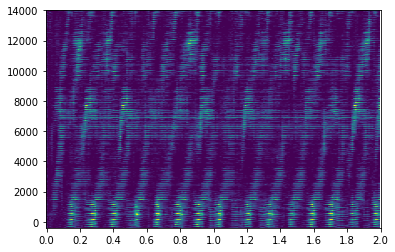

In [14]:
fig, ax = plt.subplots(1,1)
ax.imshow(spk_raster[11,0,0,:,:], aspect='auto', vmax=0.5)

xticks = np.arange(0,220,20)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xticks/100, 1))
yticks = np.arange(0,14400,2000)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks[::-1])
plt.show()

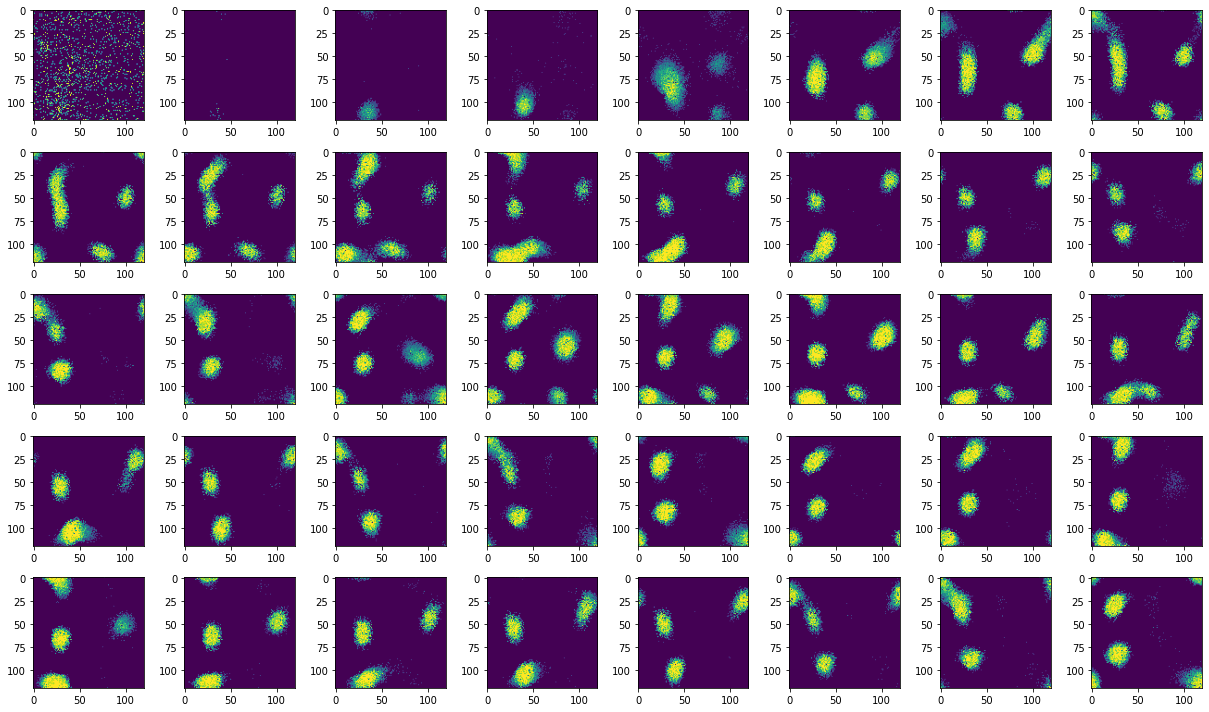

In [15]:
nrows = 5
ncols = 8
fig = plt.figure(figsize=(17,10))    
for i in range(1,nrows*ncols+1):
    ax = fig.add_subplot(nrows, ncols, i)
    ax.imshow(spk_raster[2,0,0,:,i-1].reshape(120,120))
fig.tight_layout()

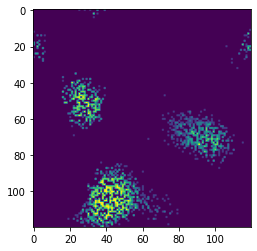

In [18]:
from matplotlib import animation

fig, ax1 = plt.subplots(1,1)
frames = [] # store generated images
for i in range(n_bins):
    img1 = ax1.imshow(spk_raster[7,1,0,:,i].reshape(120,120), animated=True)
    frames.append([img1])

ani = animation.ArtistAnimation(fig, frames, interval=150, blit=True,
                                repeat_delay=1000)
ani.save('movies/test.mp4')

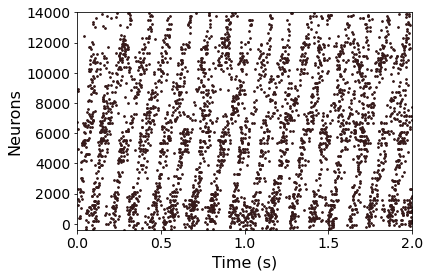

In [19]:
filename = 'spike_raster'
p_off = 0.6
subspace = 4
fig, ax = plt.subplots(1,1, figsize=(6,4))
for trial in range(n_trials):
    gs = np.load(data_dir + 'bg_noise_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_i.npy')
    ts = np.load(data_dir + 'bg_noise_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_t.npy')
    plt.scatter(ts[np.arange(0,len(ts),100)], gs[np.arange(0,len(ts),100)], s=3, color=colors[11])

ax.set_xlim(0,2)
ax.set_ylim(14400,0)
xticks = np.arange(0,2.2,0.5).round(1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=14)
yticks = np.arange(0,14400,2000)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks[::-1], fontsize=14)
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_ylabel('Neurons', fontsize=16)

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

In [20]:
bins = np.linspace(0,0.4,simtime//window +1)

(0.0, 120.0)

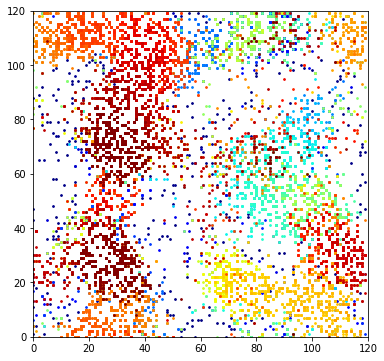

In [21]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = cmap(np.linspace( 0, 1, simtime//window)) [:,:3]

plt.figure(figsize=(6,6))
for t in range(simtime//window):
    t1 = bins[t]
    t2 = bins[t+1]
    xx = gs[(ts<=t2) & (ts>t1)] % 120
    yy = gs[(ts<=t2) & (ts>t1)] // 120
    plt.scatter(xx,yy, s=3, color=cmaplist[t])
plt.xlim(0,120)
plt.ylim(0,120)

### Perlin

In [22]:
np.max(sn.neuron_groups['e'].x_shift[:])

0.025

In [23]:
np.max(sn.neuron_groups['e'].y_shift[:])

0.024999460051421882

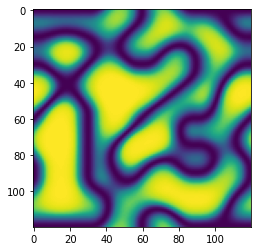

In [24]:
plt.imshow(sn.neuron_groups['e'].x_shift[:].reshape(120,120))

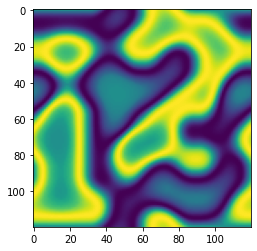

In [25]:
plt.imshow(sn.neuron_groups['e'].y_shift[:].reshape(120,120))

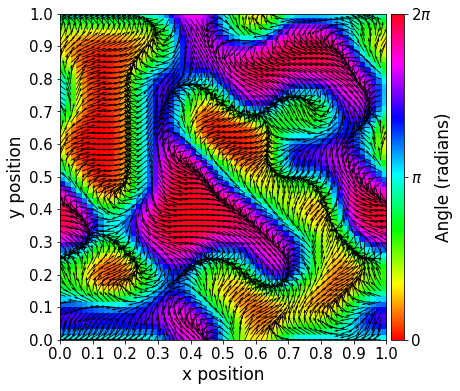

In [26]:
from perlin import generate_perlin

filename='perlin_landscape'
#net = Network()
landscape = generate_perlin(120, 4, seed_value=0)
U = np.cos(landscape)
V = np.sin(landscape)

ticks = np.round(np.arange(0,1.1,.1),1)

s = 2
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(landscape[::s, ::s], cmap='hsv', origin='lower', extent=(0, 60, 0, 60))
ax.set_xticks(np.arange(0,132,12)/s, np.round(np.arange(0,1.1,.1),1), fontsize=15)
ax.set_yticks(np.arange(0,132,12)/s, np.round(np.arange(0,1.1,.1),1), fontsize=15)
ax.set_xlabel('x position', fontsize=17)
ax.set_ylabel('y position', fontsize=17)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, ticks=[0, np.pi, 2*np.pi])
cbar.ax.set_yticklabels(['0', '$\pi$', '$2 \pi$'], fontsize=15)  
cbar.ax.set_ylabel('Angle (radians)', fontsize=17)

ax.quiver(U[::s, ::s], V[::s, ::s],scale=5,linewidth=0.4, scale_units='inches') #, label='Winds')

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

### Plot activity across time

In [27]:
window

10

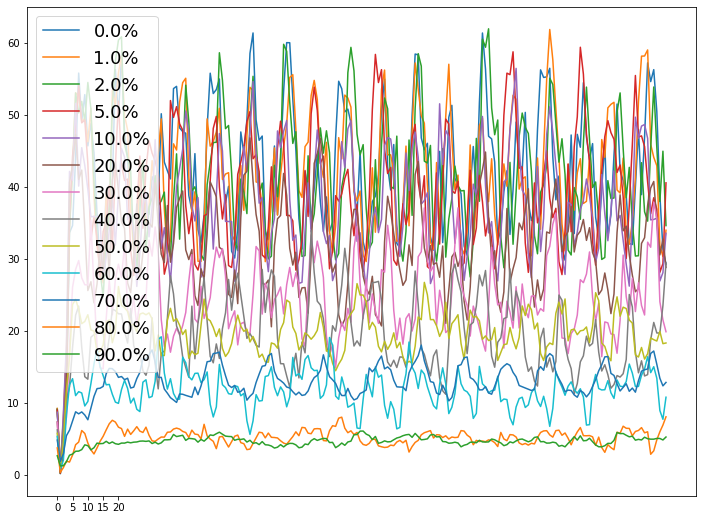

In [28]:
plt.figure(figsize=(12,9))
for i, p in enumerate(p_offs):
        plt.plot(np.mean(spk_raster[i,0,0,:,:], axis=0)*1000/window, label=str(100*p)+'%')

plt.xticks(np.arange(0,25,5))
plt.legend(fontsize=18)
plt.show()

## PCA results

In [29]:
n_components = 30
pca_dict = {}
exp_var = np.zeros((n_p_offs, n_subspaces, n_trials, n_components))
for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):
        for trial in range(n_trials):
            # note that we transpose the spike raster for the scaling and PCA, requires (n_samples, n_features)
            spk_raster_centered = StandardScaler().fit_transform(spk_raster[p_off_i, subspace, trial, :, :].T)
            pca_dict[p_off_i, subspace, trial] = decomposition.PCA(n_components=n_components)
            pca_dict[p_off_i, subspace, trial].fit_transform(spk_raster_centered)

            # cumulative variance
            exp_var[p_off_i, subspace, trial,:] = pca_dict[p_off_i, subspace, trial].explained_variance_ratio_.cumsum()

#### Explained variance

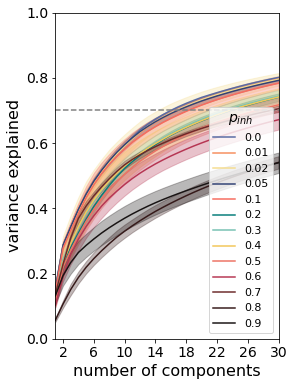

In [30]:
filename = 'var_exp'
plt.figure(figsize=(4,6))
for p_off_i, p_off in enumerate(p_offs):
    plt.plot(np.arange(1,n_components+1), exp_var[p_off_i, :, :, :].mean(axis=(0,1)), color=colors[p_off_i], label=p_off)
    plt.fill_between(np.arange(1,n_components+1),
                     exp_var[p_off_i, :, :, :].mean(axis=(0,1)) - exp_var[p_off_i, :, :, :].std(axis=(0,1)),
                     exp_var[p_off_i, :, :, :].mean(axis=(0,1)) + exp_var[p_off_i, :, :, :].std(axis=(0,1)), 
                     color=colors[p_off_i], alpha=0.3)
        
plt.xlim(1,12)
plt.ylim(0,1)
plt.xticks(np.arange(2,n_components+1,4), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('variance explained', fontsize=16)
plt.axhline(0.7, color='grey', linestyle='--')
legend = plt.legend(fontsize=11, title='$p_{inh}$')
legend.get_title().set_fontsize('14')

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

### Principal angles, all subnets

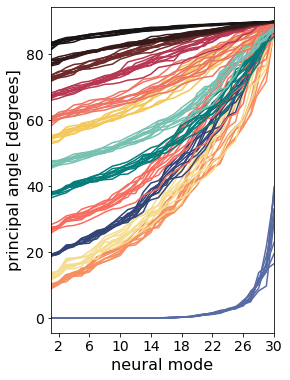

In [31]:
filename = 'principal_angles'
plt.figure(figsize=(4,6))

angles = np.zeros((n_p_offs, int(n_subspaces*(n_subspaces-1)/2), n_trials))

for p_off_i, p_off in enumerate(p_offs):
    count = 0
    for subspace_i in range(n_subspaces):
        for subspace_j in range(subspace_i+1, n_subspaces):
            for trial in range(n_trials):
                pc_i = pca_dict[p_off_i, subspace_i, trial].components_
                pc_j = pca_dict[p_off_i, subspace_j, trial].components_.T
            
                u, s, vh = np.linalg.svd(np.dot(pc_i, pc_j), full_matrices=True)
                angles[p_off_i, count, trial] = (np.arccos(np.clip(s,-1,1))*180/np.pi)[0]
            
                if subspace_i == 0 and subspace_j == 1 and trial == 0:
                    plt.plot(np.arange(1,n_components+1),np.arccos(np.clip(s,-1,1))*180/np.pi, colors[p_off_i%len(colors)], label=str(p_off))
                else:
                    plt.plot(np.arange(1,n_components+1),np.arccos(np.clip(s,-1,1))*180/np.pi, colors[p_off_i%len(colors)])

            count+=1
plt.xticks(np.arange(2,n_components+1,4), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('neural mode', fontsize=16)
plt.ylabel('principal angle [degrees]', fontsize=16)
plt.xlim(1,30)

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

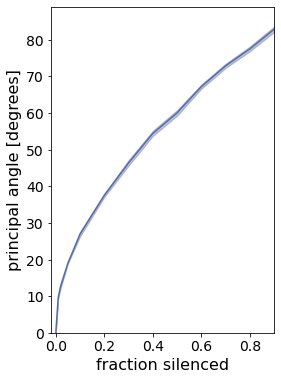

In [32]:
filename = 'average_principal_angles'
plt.figure(figsize=(4,6))
#plt.plot(p_offs, np.arccos(1-p_offs)*180/np.pi, color='grey', linestyle='--')
plt.plot(p_offs, angles.mean(axis=(1,2)), color=colors[0])
plt.fill_between(p_offs,
                 angles.mean(axis=(1,2)) - np.std(angles, axis=(1,2)),
                 angles.mean(axis=(1,2)) + np.std(angles, axis=(1,2)), 
                 color=colors[0], alpha=0.4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('fraction silenced', fontsize=16)
plt.ylabel('principal angle [degrees]', fontsize=16)
#plt.axhline(0.7, color='grey', linestyle='--')
#plt.legend(fontsize=12)
plt.xlim(-0.02,0.9)
plt.ylim(0,89)

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

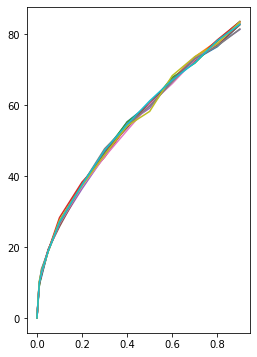

In [33]:
plt.figure(figsize=(4,6))
plt.plot(p_offs, angles.mean(axis=2))

### Additional analysis, not in published paper

### Single neurons

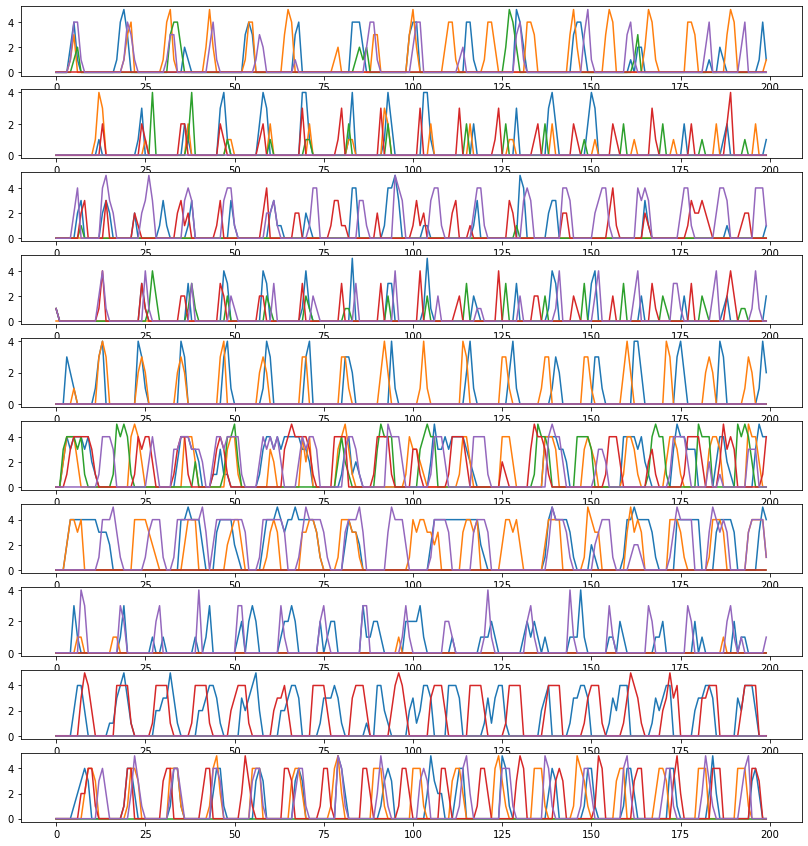

In [34]:
#p_off_i, subspace, trial, :, j
k = 7
n_exs = 10
t_start = 0

inds = spk_raster[k,0,0,:,:].sum(axis=1) > 50
neuron_exs = np.random.choice(np.where(inds==True)[0], n_exs)

sing_neuron_colors = ['#586ba4', '#f76c5e']
fig, axs = plt.subplots(n_exs, figsize=(14,15))

for ex_i, ex in enumerate(neuron_exs):
    for i in range(n_subspaces):
        axs[ex_i].plot(np.arange(t_start,n_bins), 
                       np.mean(spk_raster[k, i,:,ex,t_start:], axis=0))
        axs[ex_i].fill_between(np.arange(t_start,n_bins),
                               np.mean(spk_raster[k, i,:,ex,t_start:], axis=0) - np.std(spk_raster[k, i,:,ex,t_start:], axis=0),
                               np.mean(spk_raster[k, i,:,ex,t_start:], axis=0) + np.std(spk_raster[k, i,:,ex,t_start:], axis=0), alpha=0.2)
plt.show()

In [37]:
complete_silencing = np.zeros((n_p_offs, n_subspaces, n_trials)) 
for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):
        for trial in range(n_trials):
            active = spk_raster[p_off_i, subspace, trial].sum(axis=1) > 0 
            inhibited = on_offs_e[p_off, subspace] == 500
            complete_silencing[p_off_i, subspace, trial] = nPopE * p_off - (~active & inhibited).sum()

In [38]:
complete_silencing

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.]]])